   district  hospital_count  beauty_count  pharmacy_count  animal_trust_count
0       강남구            94.0         154.0           287.0               102.0
1       강동구            47.0          87.0           156.0                37.0
2       강북구            27.0          56.0            69.0                28.0
3       강서구            50.0         101.0           146.0                60.0
4       관악구            27.0          57.0           118.0                34.0
5       광진구            33.0          56.0            89.0                22.0
6       구로구            29.0          45.0            92.0                13.0
7       금천구            16.0          40.0            62.0                24.0
8       노원구            45.0          83.0           117.0                24.0
9       도봉구            26.0          59.0            73.0                21.0
10     동대문구            32.0          57.0            92.0                30.0
11      동작구            21.0          43.0            67.0       

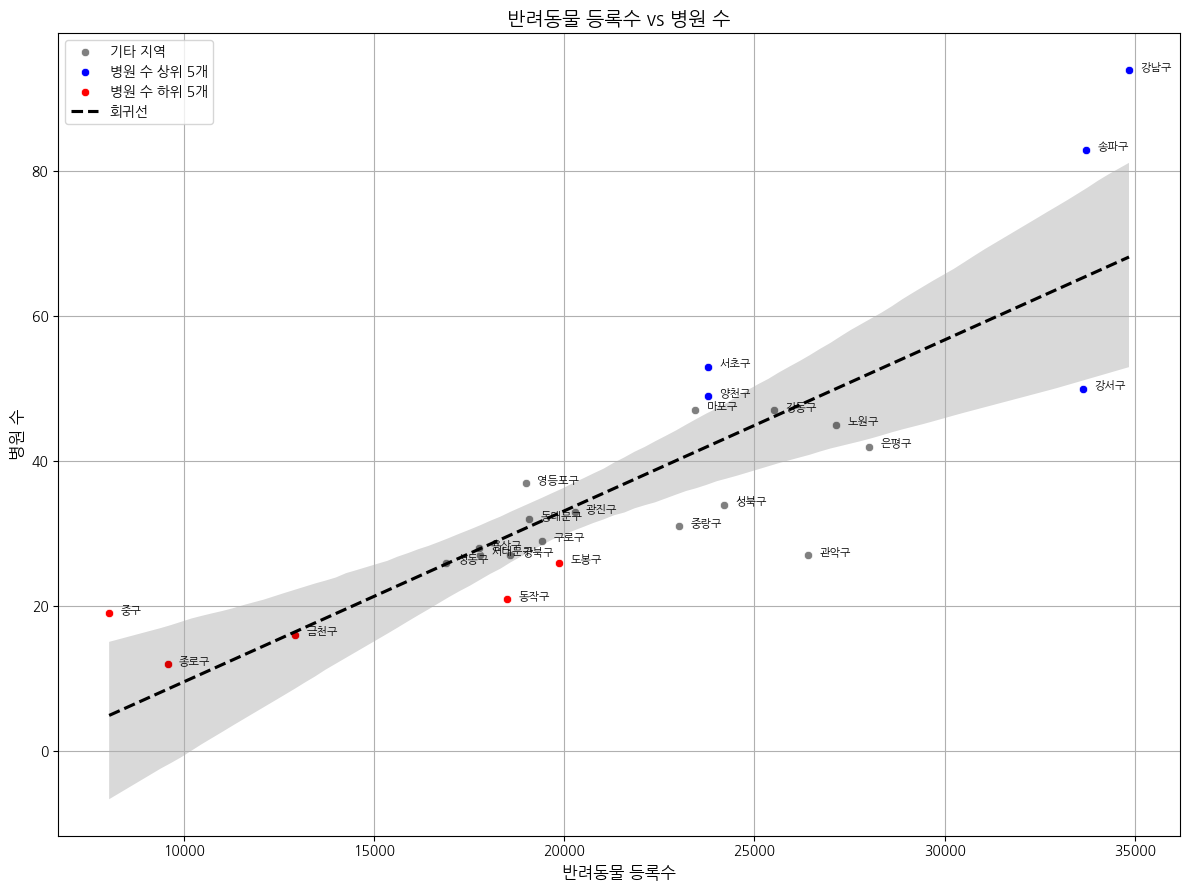

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
from sqlalchemy import create_engine
from shapely.geometry import shape
from io import BytesIO
import base64
import seaborn as sns

from dotenv import load_dotenv
import os
import json

df=pd.read_csv('/home/jiming/dev_ws/eda-repo-3/RESULT/csv/seoul_integrated_data.csv')

# 동물 시설 관련 column만 사용하기
df_filterd = df.iloc[:, :7]
df_filterd.drop(columns=['companion_animal_registration'], inplace=True)
df_filterd.drop(columns=['seoul_animal_hospital'],inplace=True)
print(df_filterd)



#=============


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # 예시 facility 데이터 (위 데이터)
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 병원 수 기준으로 상위/하위 5개 구 추출
top5 = df.nlargest(5, 'hospital_count')
bottom5 = df.nsmallest(5, 'hospital_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

import numpy as np  # 꼭 있어야 함

# 회귀선 기울기 및 절편 계산
slope, intercept = np.polyfit(df['total_registered'], df['hospital_count'], 1)
print(f"회귀선 기울기: {slope:.4f}, 절편: {intercept:.2f}")

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='hospital_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='hospital_count', label='병원 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='hospital_count', label='병원 수 하위 5개', color='red')

# 회귀선 (신뢰구간 제거)
sns.regplot(data=df, x='total_registered', y='hospital_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"},  label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,  # x축이 등록수니까 수치 조정
             y=df.loc[i, 'hospital_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 병원 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('병원 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# ▶️ 이미지 저장 경로 지정
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/병원수VS등록수_회귀선_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # 폴더가 없으면 생성
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # 고해상도 저장

plt.show()

   district  hospital_count  beauty_count  pharmacy_count  animal_trust_count
0       강남구            94.0         154.0           287.0               102.0
1       강동구            47.0          87.0           156.0                37.0
2       강북구            27.0          56.0            69.0                28.0
3       강서구            50.0         101.0           146.0                60.0
4       관악구            27.0          57.0           118.0                34.0
5       광진구            33.0          56.0            89.0                22.0
6       구로구            29.0          45.0            92.0                13.0
7       금천구            16.0          40.0            62.0                24.0
8       노원구            45.0          83.0           117.0                24.0
9       도봉구            26.0          59.0            73.0                21.0
10     동대문구            32.0          57.0            92.0                30.0
11      동작구            21.0          43.0            67.0       

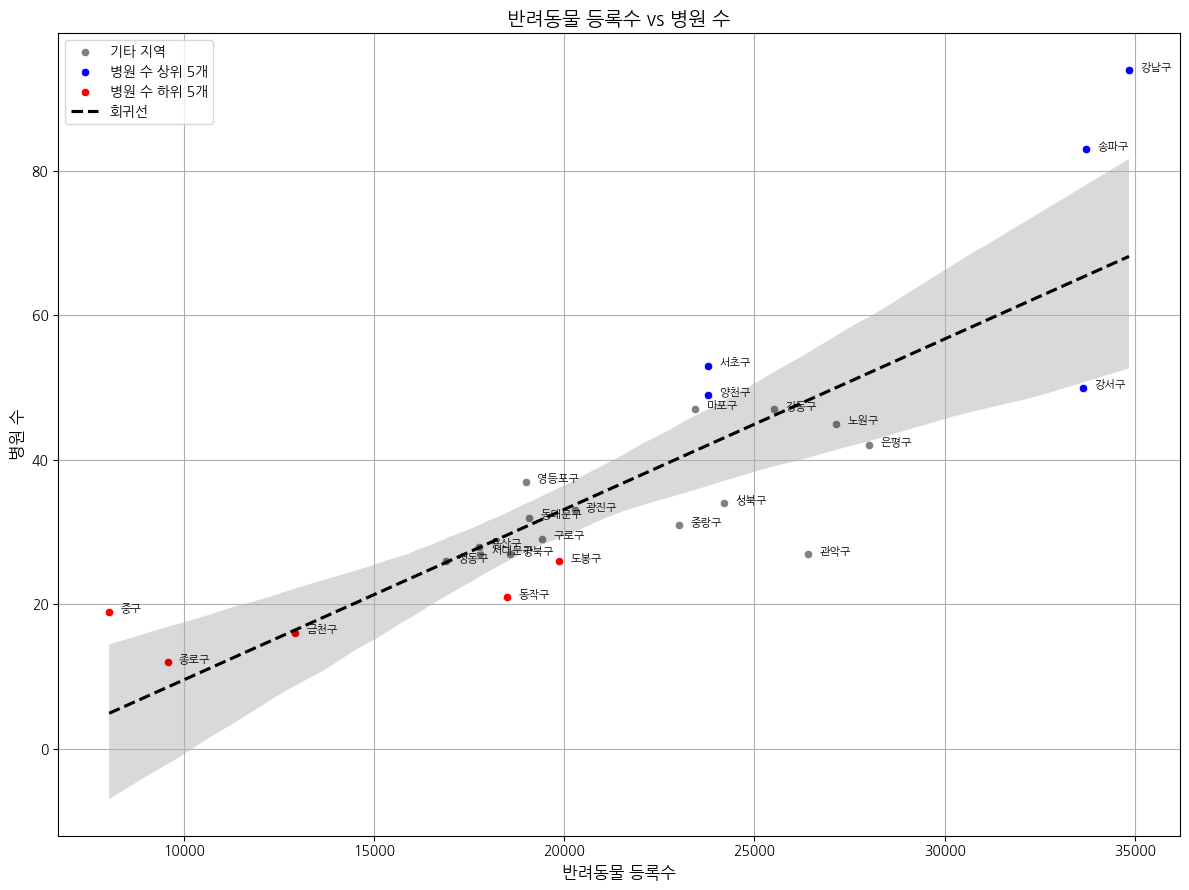

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
from sqlalchemy import create_engine
from shapely.geometry import shape
from io import BytesIO
import base64
import seaborn as sns

from dotenv import load_dotenv
import os
import json

df=pd.read_csv('/home/jiming/dev_ws/eda-repo-3/RESULT/csv/seoul_integrated_data.csv')

# 동물 시설 관련 column만 사용하기
df_filterd = df.iloc[:, :7]
df_filterd.drop(columns=['companion_animal_registration'], inplace=True)
df_filterd.drop(columns=['seoul_animal_hospital'],inplace=True)
print(df_filterd)



#=============


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # 예시 facility 데이터 (위 데이터)
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 병원 수 기준으로 상위/하위 5개 구 추출
top5 = df.nlargest(5, 'hospital_count')
bottom5 = df.nsmallest(5, 'hospital_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

import numpy as np  # 꼭 있어야 함

# 회귀선 기울기 및 절편 계산
slope, intercept = np.polyfit(df['total_registered'], df['hospital_count'], 1)
print(f"회귀선 기울기: {slope:.4f}, 절편: {intercept:.2f}")

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='hospital_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='hospital_count', label='병원 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='hospital_count', label='병원 수 하위 5개', color='red')

# 회귀선 (신뢰구간 제거)
sns.regplot(data=df, x='total_registered', y='hospital_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"},  label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,  # x축이 등록수니까 수치 조정
             y=df.loc[i, 'hospital_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 병원 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('병원 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# ▶️ 이미지 저장 경로 지정
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/병원수VS등록수_회귀선_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # 폴더가 없으면 생성
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # 고해상도 저장

plt.show()

# 정규화한 반려동물 VS 병원수

정규화된 회귀선 기울기: 0.7714, 절편: -0.0864


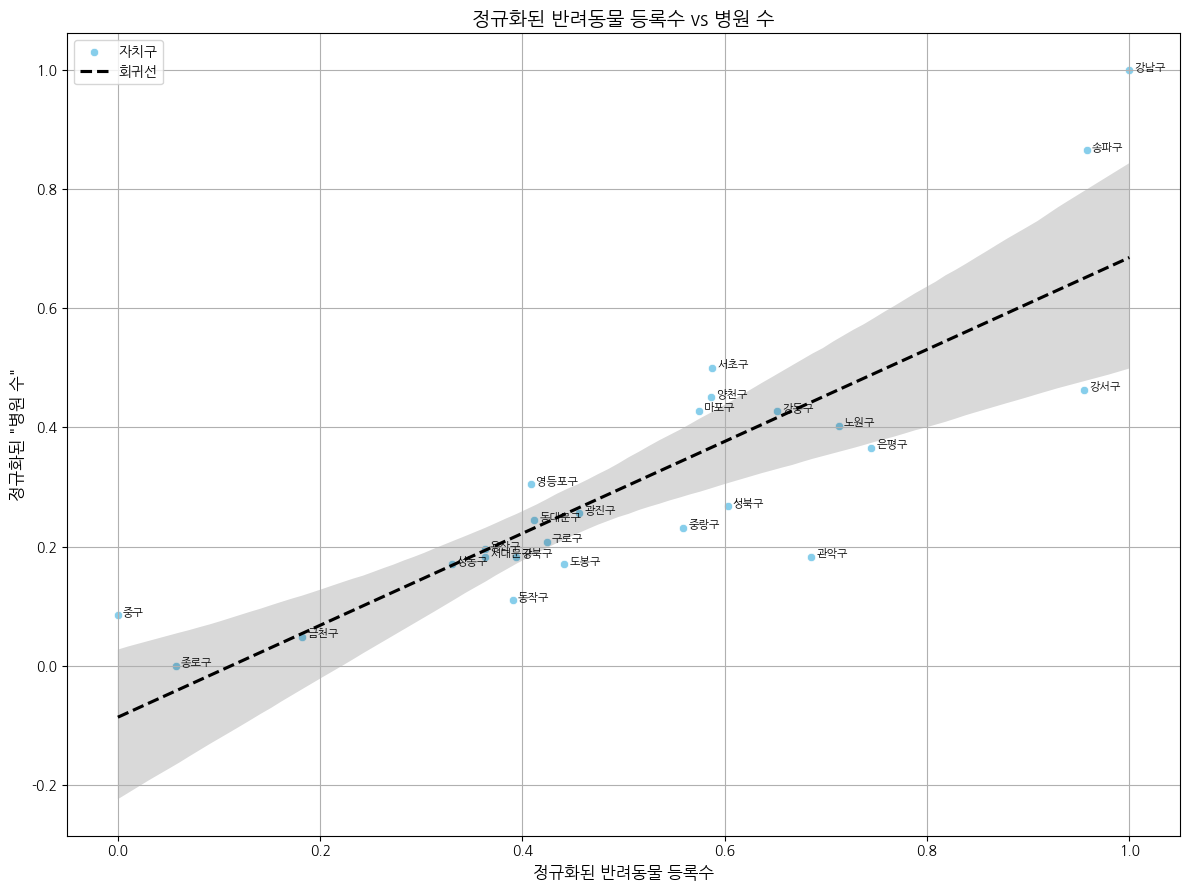

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# 예시 데이터 불러오기
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 정규화
scaler = MinMaxScaler()
df[['total_registered_norm', 'hospital_count_norm']] = scaler.fit_transform(df[['total_registered', 'hospital_count']])

# 회귀선 기울기 계산 (정규화된 데이터 사용)
slope, intercept = np.polyfit(df['total_registered_norm'], df['hospital_count_norm'], 1)
print(f"정규화된 회귀선 기울기: {slope:.4f}, 절편: {intercept:.4f}")

# 시각화
plt.figure(figsize=(12, 9))

# 산점도
sns.scatterplot(data=df, x='total_registered_norm', y='hospital_count_norm', color='skyblue', label='자치구')

# 회귀선
sns.regplot(data=df, x='total_registered_norm', y='hospital_count_norm',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered_norm'] + 0.005,
             y=df.loc[i, 'hospital_count_norm'],
             s=df.loc[i, 'district'],
             fontsize=8)

plt.title('정규화된 반려동물 등록수 vs 병원 수', fontsize=14)
plt.xlabel('정규화된 반려동물 등록수', fontsize=12)
plt.ylabel('정규화된 "병원 수"', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 저장
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/정규화_병원수VS등록수_회귀선_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')


# 이미지 저장
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/정규화/정규화_반려동물_병원수.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


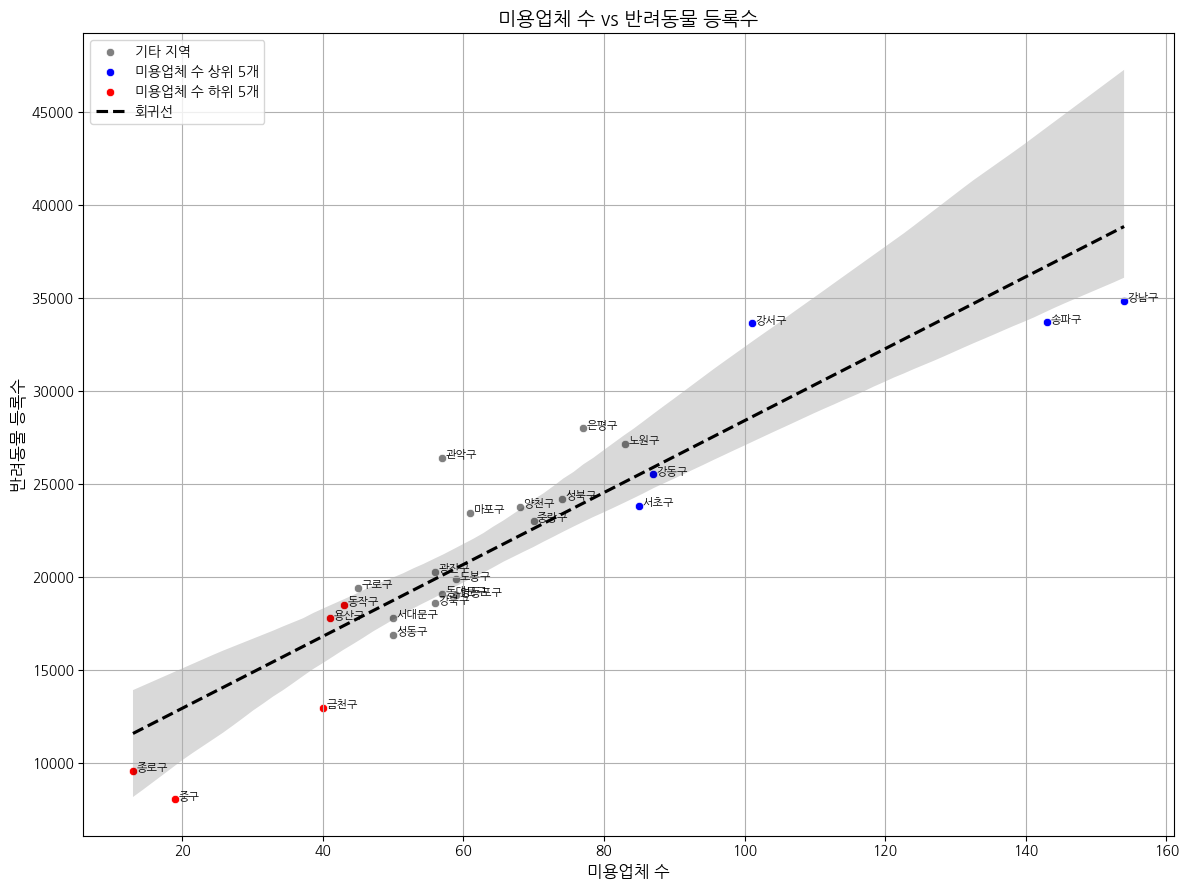

In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # 예시 facility 데이터 (위 데이터)
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 상위/하위 5개 구 추출 (beauty_count 기준)
top5 = df.nlargest(5, 'beauty_count')
bottom5 = df.nsmallest(5, 'beauty_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='beauty_count', y='total_registered', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='beauty_count', y='total_registered', label='미용업체 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='beauty_count', y='total_registered', label='미용업체 수 하위 5개', color='red')

# 회귀선 (신뢰구간 제거)
sns.regplot(data=df, x='beauty_count', y='total_registered',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'beauty_count'] + 0.5,
             y=df.loc[i, 'total_registered'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('미용업체 수 vs 반려동물 등록수', fontsize=14)
plt.xlabel('미용업체 수', fontsize=12)
plt.ylabel('반려동물 등록수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/미용업체수_VS_등록수_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


# 미용업체 정규화

정규화된 회귀선 기울기: 0.8221, 절편: -0.0469


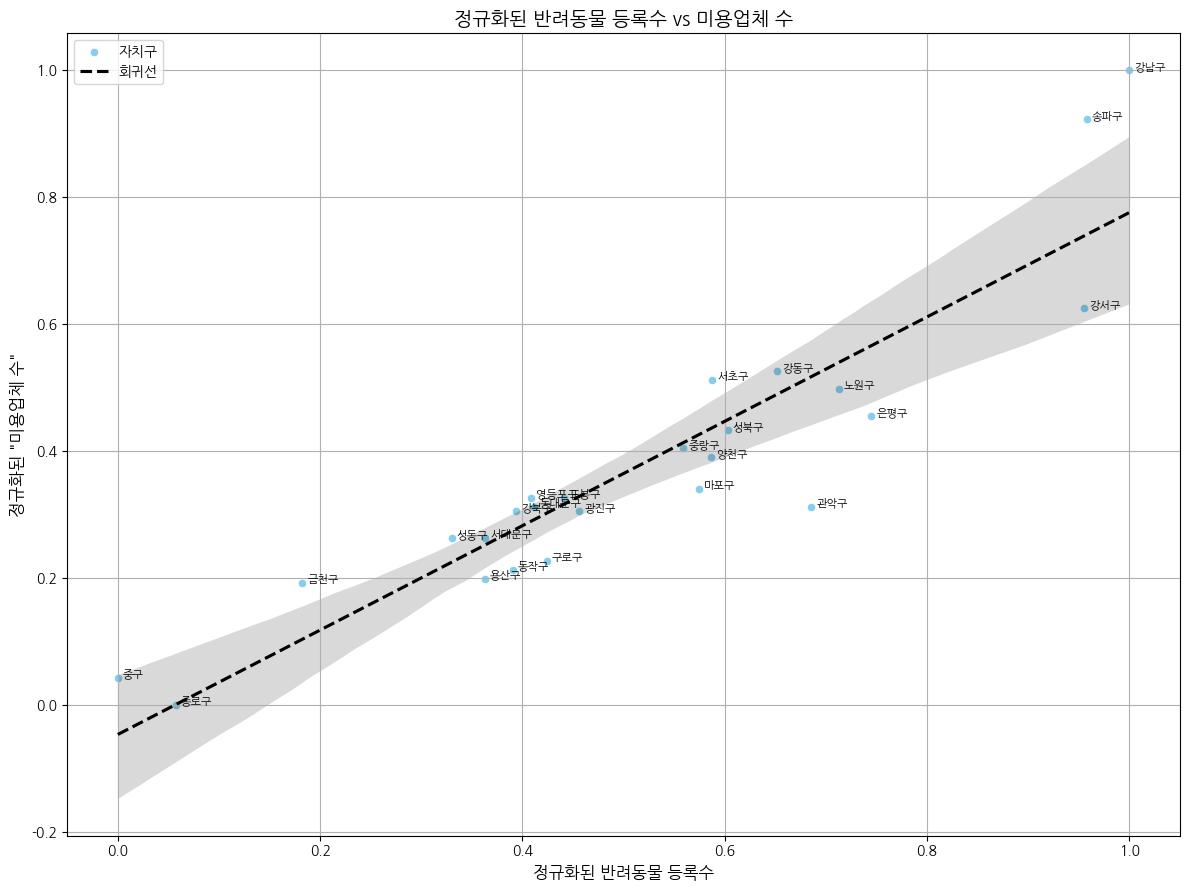

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# 예시 데이터 불러오기
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 정규화
scaler = MinMaxScaler()
df[['total_registered_norm', 'beauty_count_norm']] = scaler.fit_transform(df[['total_registered', 'beauty_count']])

# 회귀선 기울기 계산 (정규화된 데이터 사용)
slope, intercept = np.polyfit(df['total_registered_norm'], df['beauty_count_norm'], 1)
print(f"정규화된 회귀선 기울기: {slope:.4f}, 절편: {intercept:.4f}")

# 시각화
plt.figure(figsize=(12, 9))

# 산점도
sns.scatterplot(data=df, x='total_registered_norm', y='beauty_count_norm', color='skyblue', label='자치구')

# 회귀선
sns.regplot(data=df, x='total_registered_norm', y='beauty_count_norm',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered_norm'] + 0.005,
             y=df.loc[i, 'beauty_count_norm'],
             s=df.loc[i, 'district'],
             fontsize=8)

plt.title('정규화된 반려동물 등록수 vs 미용업체 수', fontsize=14)
plt.xlabel('정규화된 반려동물 등록수', fontsize=12)
plt.ylabel('정규화된 "미용업체 수"', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()


# 이미지 저장
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/정규화/정규화_미용업체_병원수.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


회귀선 기울기: 0.004325, 절편: -28.40


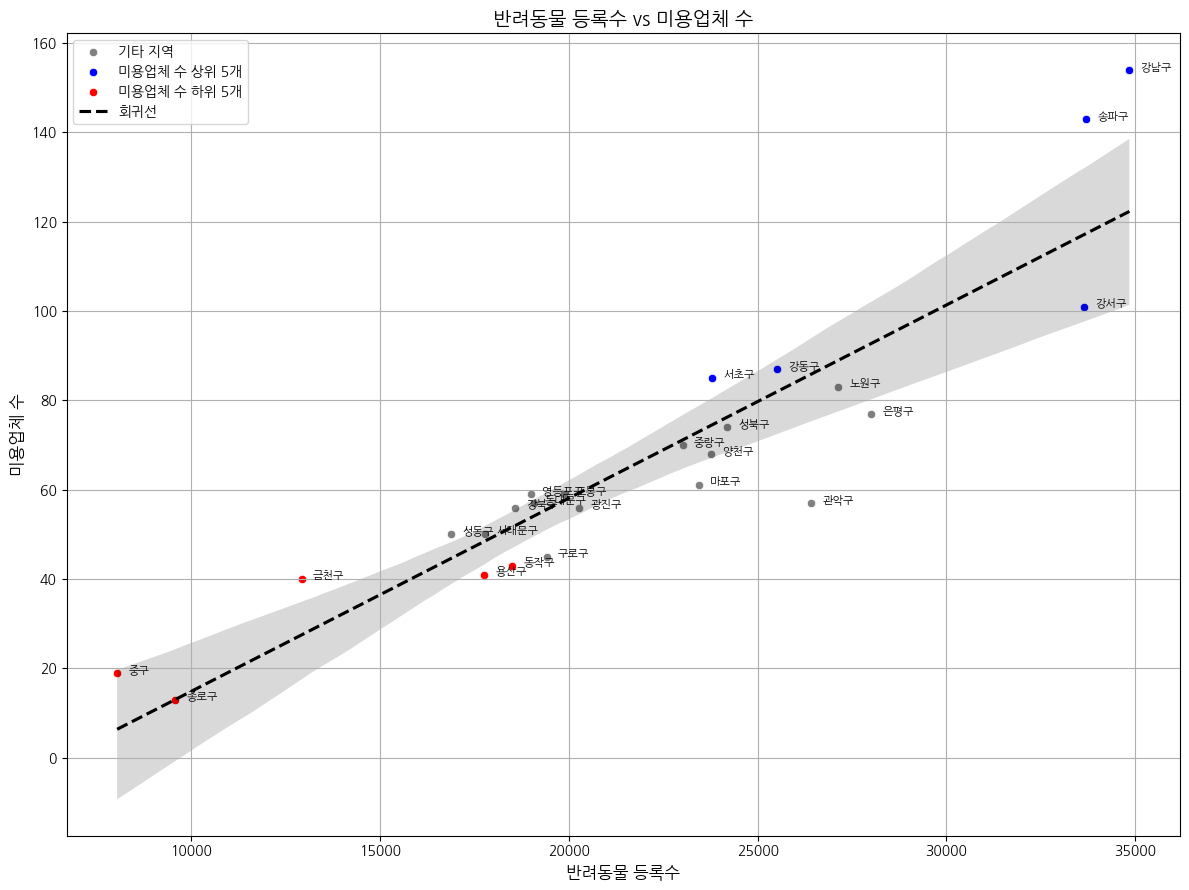

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np  # 회귀선 기울기 구할 때 필요

# 예시 facility 데이터
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

# 데이터 병합
df = pd.merge(facility_df, register_df, on='district')

# 상위/하위 5개 구 추출 (beauty_count 기준)
top5 = df.nlargest(5, 'beauty_count')
bottom5 = df.nsmallest(5, 'beauty_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

# 회귀선 기울기 및 절편 계산 (x축: total_registered, y축: beauty_count)
slope, intercept = np.polyfit(df['total_registered'], df['beauty_count'], 1)
print(f"회귀선 기울기: {slope:.6f}, 절편: {intercept:.2f}")

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='beauty_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='beauty_count', label='미용업체 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='beauty_count', label='미용업체 수 하위 5개', color='red')

# 회귀선 (신뢰구간 제거)
sns.regplot(data=df, x='total_registered', y='beauty_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,
             y=df.loc[i, 'beauty_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 미용업체 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('미용업체 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/미용업체수_VS_등록수_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


#

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 상위/하위 5개 구 추출 (beauty_count 기준)
top5 = df.nlargest(5, 'beauty_count')
bottom5 = df.nsmallest(5, 'beauty_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='beauty_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='beauty_count', label='미용업체 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='beauty_count', label='미용업체 수 하위 5개', color='red')

# 회귀선 (신뢰구간 제거)
sns.regplot(data=df, x='total_registered', y='beauty_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, ci=None, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,
             y=df.loc[i, 'beauty_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 미용업체 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('미용업체 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_미용업체수_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


회귀선 기울기: 0.0059, 절편: -24.14


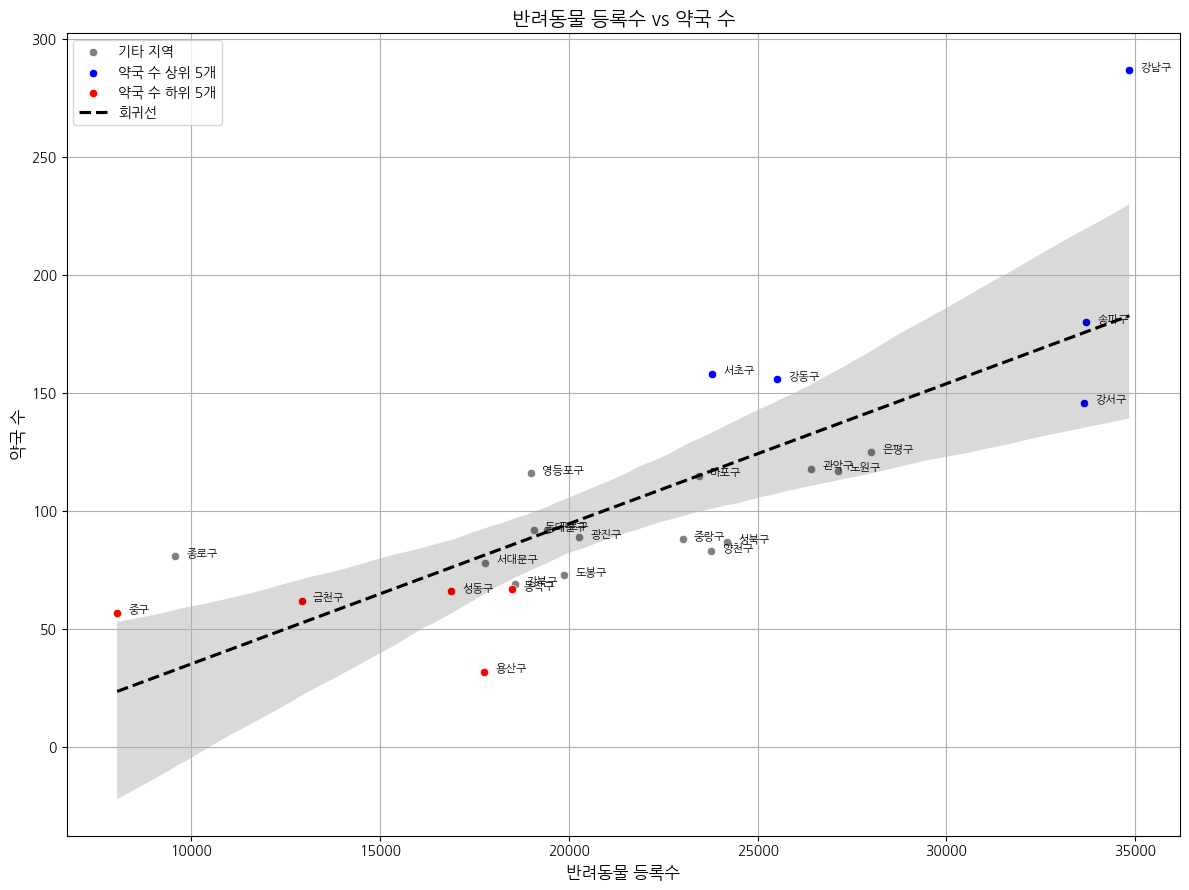

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # 예시 facility 데이터 (위 데이터)
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 약국 수 기준 top5 / bottom5
top5 = df.nlargest(5, 'pharmacy_count')
bottom5 = df.nsmallest(5, 'pharmacy_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]


import numpy as np  # 꼭 있어야 함

# 회귀선 기울기 및 절편 계산
slope, intercept = np.polyfit(df['total_registered'], df['pharmacy_count'], 1)
print(f"회귀선 기울기: {slope:.4f}, 절편: {intercept:.2f}")

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='pharmacy_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='pharmacy_count', label='약국 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='pharmacy_count', label='약국 수 하위 5개', color='red')

# 회귀선 (신뢰구간 포함)
sns.regplot(data=df, x='total_registered', y='pharmacy_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,
             y=df.loc[i, 'pharmacy_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 약국 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('약국 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_약국수_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

회귀선 기울기: 0.0026, 절편: -23.98


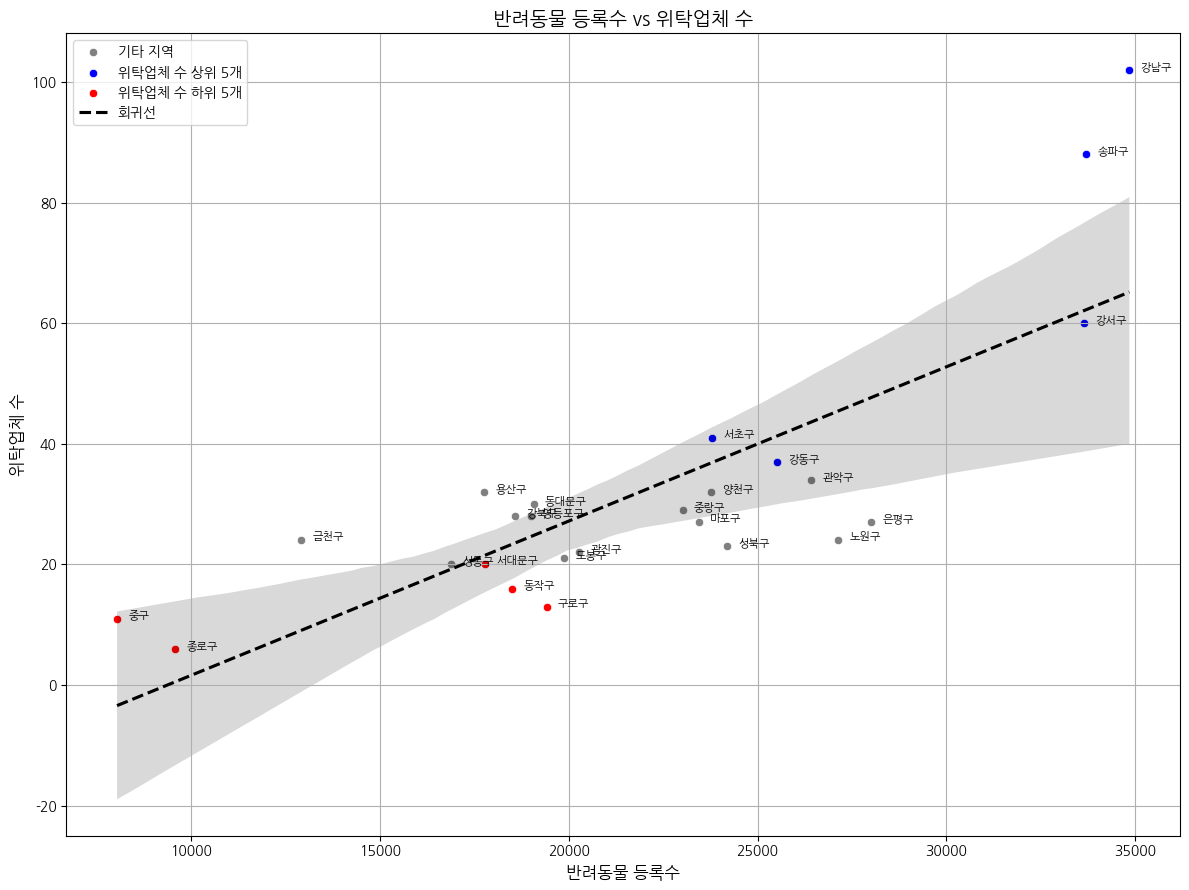

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # 예시 facility 데이터 (위 데이터)
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 위탁업체 수 기준으로 상위/하위 5개 추출
top5 = df.nlargest(5, 'animal_trust_count')
bottom5 = df.nsmallest(5, 'animal_trust_count')
middle = df[~df['district'].isin(top5['district']) & ~df['district'].isin(bottom5['district'])]

import numpy as np  # 꼭 있어야 함

# 회귀선 기울기 및 절편 계산
slope, intercept = np.polyfit(df['total_registered'], df['animal_trust_count'], 1)
print(f"회귀선 기울기: {slope:.4f}, 절편: {intercept:.2f}")

# 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹 (회색)
sns.scatterplot(data=middle, x='total_registered', y='animal_trust_count', label='기타 지역', color='gray')

# 상위 5개 (파란색)
sns.scatterplot(data=top5, x='total_registered', y='animal_trust_count', label='위탁업체 수 상위 5개', color='blue')

# 하위 5개 (빨간색)
sns.scatterplot(data=bottom5, x='total_registered', y='animal_trust_count', label='위탁업체 수 하위 5개', color='red')

# 회귀선 (신뢰구간 포함)
sns.regplot(data=df, x='total_registered', y='animal_trust_count',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered'] + 300,
             y=df.loc[i, 'animal_trust_count'],
             s=df.loc[i, 'district'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 위탁업체 수', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('위탁업체 수', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_위탁업체수_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# 정규화된 위탁업체

정규화된 회귀선 기울기: 0.7142, 절편: -0.0980


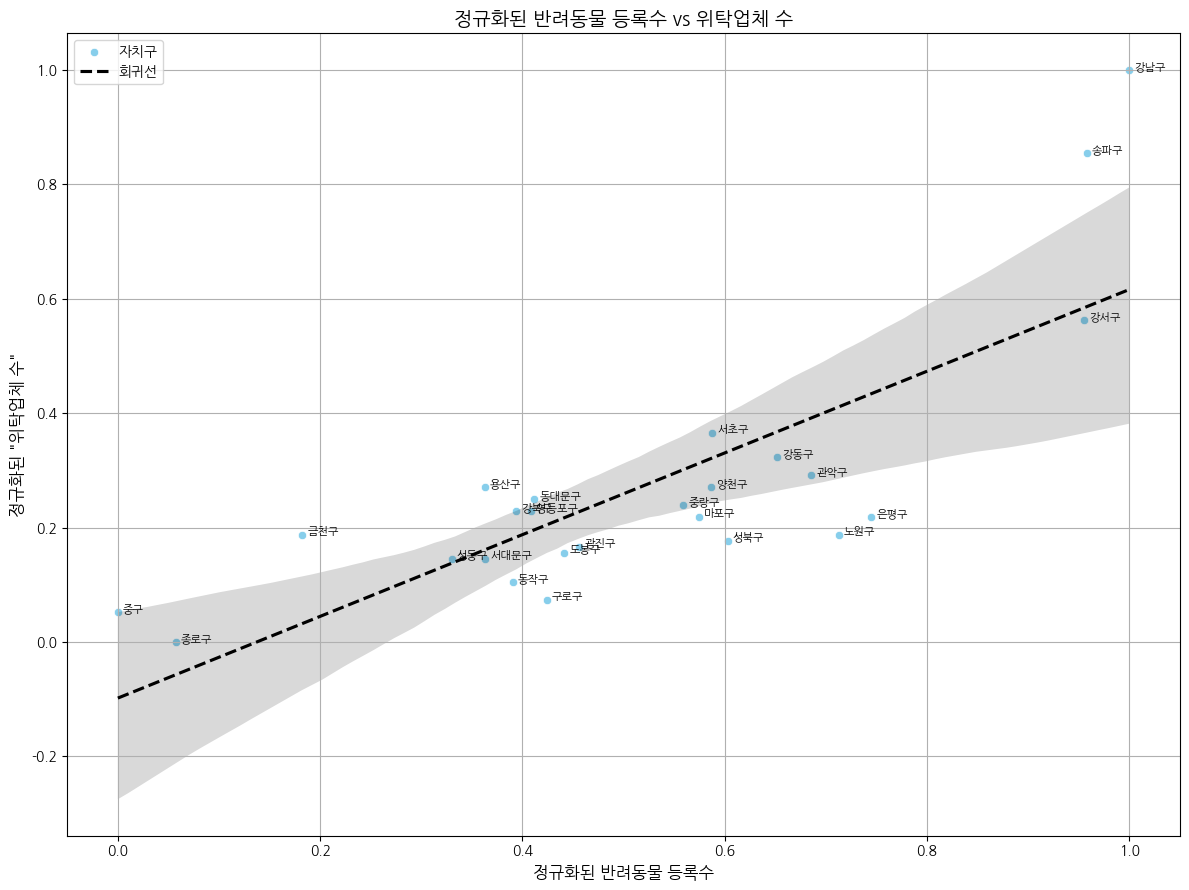

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# 예시 데이터 불러오기
facility_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'hospital_count': [94, 47, 27, 50, 27, 33, 29, 16, 45, 26, 32, 21, 47, 27, 53, 26, 34, 83, 49, 37, 28, 42, 12, 19, 31],
    'beauty_count': [154, 87, 56, 101, 57, 56, 45, 40, 83, 59, 57, 43, 61, 50, 85, 50, 74, 143, 68, 59, 41, 77, 13, 19, 70],
    'pharmacy_count': [287, 156, 69, 146, 118, 89, 92, 62, 117, 73, 92, 67, 115, 78, 158, 66, 87, 180, 83, 116, 32, 125, 81, 57, 88],
    'animal_trust_count': [102, 37, 28, 60, 34, 22, 13, 24, 24, 21, 30, 16, 27, 20, 41, 20, 23, 88, 32, 28, 32, 27, 6, 11, 29]
})

register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

df = pd.merge(facility_df, register_df, on='district')

# 정규화
scaler = MinMaxScaler()
df[['total_registered_norm', 'animal_trust_count_norm']] = scaler.fit_transform(df[['total_registered', 'animal_trust_count']])

# 회귀선 기울기 계산 (정규화된 데이터 사용)
slope, intercept = np.polyfit(df['total_registered_norm'], df['animal_trust_count_norm'], 1)
print(f"정규화된 회귀선 기울기: {slope:.4f}, 절편: {intercept:.4f}")

# 시각화
plt.figure(figsize=(12, 9))

# 산점도
sns.scatterplot(data=df, x='total_registered_norm', y='animal_trust_count_norm', color='skyblue', label='자치구')

# 회귀선
sns.regplot(data=df, x='total_registered_norm', y='animal_trust_count_norm',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 추가
for i in range(df.shape[0]):
    plt.text(x=df.loc[i, 'total_registered_norm'] + 0.005,
             y=df.loc[i, 'animal_trust_count_norm'],
             s=df.loc[i, 'district'],
             fontsize=8)

plt.title('정규화된 반려동물 등록수 vs 위탁업체 수', fontsize=14)
plt.xlabel('정규화된 반려동물 등록수', fontsize=12)
plt.ylabel('정규화된 "위탁업체 수"', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()


# 이미지 저장
output_path = '/home/jiming/dev_ws/eda-repo-3/RESULT/visualization/정규화/정규화_위탁업체_병원수.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
from sqlalchemy import create_engine
from shapely.geometry import shape
from io import BytesIO
import base64
import seaborn as sns

from dotenv import load_dotenv
import os
import json


# .env 파일을 찾아 환경 변수로 로드
load_dotenv("env")

# 환경 변수 가져오기
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# ▶️ MySQL 연결
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# ▶️ 공원 정보 가져오기
query = """
SELECT district_category_2, per_capita_park_area_sqm, per_capita_urban_park_area_sqm, per_capita_walkable_park_area_sqm
FROM per_capita_park_area
WHERE district_category_2  not like "서울대공원"
ORDER BY district_category_2;
"""
df = pd.read_sql(query, engine)
df.columns =['자치구', '1인당 공원 면적', '1인당 도시공원 면적', '1인당 도보생활권공원 면적']

# ▶️ 도시공원 데이터와 등록수 데이터 병합
# register_df는 기존 반려동물 등록수 DataFrame이라고 가정
df_merged = pd.merge(df, register_df, left_on='자치구', right_on='district')

# ▶️ Top5 / Bottom5 (도시공원 면적 기준)
top5 = df_merged.nlargest(5, '1인당 도시공원 면적')
bottom5 = df_merged.nsmallest(5, '1인당 도시공원 면적')
middle = df_merged[~df_merged['자치구'].isin(top5['자치구']) & ~df_merged['자치구'].isin(bottom5['자치구'])]

import numpy as np  # 꼭 있어야 함

# 회귀선 기울기 및 절편 계산
slope, intercept = np.polyfit(df['total_registered'], df['1인당 도시공원 면적'], 1)
print(f"회귀선 기울기: {slope:.4f}, 절편: {intercept:.2f}")


# ▶️ 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹
sns.scatterplot(data=middle, x='total_registered', y='1인당 도시공원 면적', label='기타 지역', color='gray')

# Top5
sns.scatterplot(data=top5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 상위 5개', color='blue')

# Bottom5
sns.scatterplot(data=bottom5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 하위 5개', color='red')

# 회귀선 (신뢰구간 포함)
sns.regplot(data=df_merged, x='total_registered', y='1인당 도시공원 면적',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 표시
for i in range(df_merged.shape[0]):
    plt.text(x=df_merged.loc[i, 'total_registered'] + 300,
             y=df_merged.loc[i, '1인당 도시공원 면적'],
             s=df_merged.loc[i, '자치구'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 1인당 도시공원 면적', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('1인당 도시공원 면적 (㎡)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# ▶️ 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_1인당_도시공원면적_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'None' ([Errno -3] Temporary failure in name resolution)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
from sqlalchemy import create_engine
from shapely.geometry import shape
from io import BytesIO
import base64
import seaborn as sns

from dotenv import load_dotenv
import os
import json


# .env 파일을 찾아 환경 변수로 로드
load_dotenv("env")

# 환경 변수 가져오기
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# ▶️ MySQL 연결
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# ▶️ 공원 정보 가져오기
query = """
SELECT district_category_2, per_capita_park_area_sqm, per_capita_urban_park_area_sqm, per_capita_walkable_park_area_sqm
FROM per_capita_park_area
WHERE district_category_2  not like "서울대공원"
ORDER BY district_category_2;
"""

df = pd.read_sql(query, engine)
df.columns =['자치구', '1인당 공원 면적', '1인당 도시공원 면적', '1인당 도보생활권공원 면적']
# 예시 반려동물 등록수 데이터
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

# ▶️ 도시공원 데이터와 등록수 데이터 병합
# register_df는 기존 반려동물 등록수 DataFrame이라고 가정
df_merged = pd.merge(df, register_df, left_on='자치구', right_on='district')

# ▶️ Top5 / Bottom5 (도시공원 면적 기준)
top5 = df_merged.nlargest(5, '1인당 도시공원 면적')
bottom5 = df_merged.nsmallest(5, '1인당 도시공원 면적')
middle = df_merged[~df_merged['자치구'].isin(top5['자치구']) & ~df_merged['자치구'].isin(bottom5['자치구'])]

# ▶️ 시각화
plt.figure(figsize=(12, 9))

# 중간 그룹
sns.scatterplot(data=middle, x='total_registered', y='1인당 도시공원 면적', label='기타 지역', color='gray')

# Top5
sns.scatterplot(data=top5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 상위 5개', color='blue')

# Bottom5
sns.scatterplot(data=bottom5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 하위 5개', color='red')

# 회귀선 (신뢰구간 포함)
sns.regplot(data=df_merged, x='total_registered', y='1인당 도시공원 면적',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 라벨 표시
for i in range(df_merged.shape[0]):
    plt.text(x=df_merged.loc[i, 'total_registered'] + 300,
             y=df_merged.loc[i, '1인당 도시공원 면적'],
             s=df_merged.loc[i, '자치구'],
             fontsize=8)

# 제목 및 축
plt.title('반려동물 등록수 vs 1인당 도시공원 면적', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('1인당 도시공원 면적 (㎡)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# ▶️ 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_1인당_도시공원면적_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'None' ([Errno -3] Temporary failure in name resolution)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv("env")

# 환경변수에서 DB 정보 불러오기
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# MySQL 연결
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# ▶️ 공원 정보 가져오기
query = """
SELECT district_category_2, per_capita_park_area_sqm, per_capita_urban_park_area_sqm, per_capita_walkable_park_area_sqm
FROM per_capita_park_area
WHERE district_category_2 NOT LIKE "서울대공원"
ORDER BY district_category_2;
"""

df = pd.read_sql(query, engine)
df.columns = ['자치구', '1인당 공원 면적', '1인당 도시공원 면적', '1인당 도보생활권공원 면적']

# ▶️ 반려동물 등록 수 데이터 (예시)
register_df = pd.DataFrame({
    'district': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
                 '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
                 '용산구', '은평구', '종로구', '중구', '중랑구'],
    'total_registered': [34843, 25515, 18585, 33636, 26408, 20272, 19412, 12925, 27138, 19873,
                         19074, 18509, 23441, 17781, 23786, 16889, 24200, 33706, 23770, 18997,
                         17760, 28005, 9577, 8042, 23018]
})

# ▶️ 공원 데이터 + 등록 수 병합
df_merged = pd.merge(df, register_df, left_on='자치구', right_on='district')

# ▶️ Top 5 / Bottom 5 자치구 추출 (도시공원 면적 기준)
top5 = df_merged.nlargest(5, '1인당 도시공원 면적')
bottom5 = df_merged.nsmallest(5, '1인당 도시공원 면적')
middle = df_merged[~df_merged['자치구'].isin(top5['자치구']) & ~df_merged['자치구'].isin(bottom5['자치구'])]

# ▶️ 시각화
plt.figure(figsize=(12, 9))

# 기타 중간 그룹
sns.scatterplot(data=middle, x='total_registered', y='1인당 도시공원 면적', label='기타 지역', color='gray')

# Top5 (파랑)
sns.scatterplot(data=top5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 상위 5개', color='blue')

# Bottom5 (빨강)
sns.scatterplot(data=bottom5, x='total_registered', y='1인당 도시공원 면적', label='도시공원 면적 하위 5개', color='red')

# 회귀선 (신뢰구간 포함)
sns.regplot(data=df_merged, x='total_registered', y='1인당 도시공원 면적',
            scatter=False, color='black', line_kws={"linestyle": "dashed"}, label='회귀선')

# 자치구 이름 라벨 표시
for i in range(df_merged.shape[0]):
    plt.text(
        x=df_merged.loc[i, 'total_registered'] + 300,
        y=df_merged.loc[i, '1인당 도시공원 면적'],
        s=df_merged.loc[i, '자치구'],
        fontsize=8
    )

# 제목 및 축 설정
plt.title('반려동물 등록수 vs 1인당 도시공원 면적', fontsize=14)
plt.xlabel('반려동물 등록수', fontsize=12)
plt.ylabel('1인당 도시공원 면적 (㎡)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# 이미지 저장
output_path = 'RESULT/visualization/등록수_VS_1인당_도시공원면적_scatter.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# 출력
plt.show()


OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'None' ([Errno -3] Temporary failure in name resolution)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# ▒ 한글 폰트 설정 (플랫폼별 처리)
import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# ▒ .env 환경변수 로드
load_dotenv('env')
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# ▒ DB 연결
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# 데이터 조회: 서울특별시의 자치구별 월별 CO 농도
query = """
SELECT 
    city AS 자치구,
    january, february, march, april, may, june, 
    july, august, september, october, november, december
FROM pollution_co_concentration_by_station
WHERE province = '서울특별시'
"""

df = pd.read_sql(query, engine)

# 월별 long format으로 변환
df_melted = df.melt(id_vars='자치구', 
                    value_vars=['january', 'february', 'march', 'april', 'may', 'june',
                                'july', 'august', 'september', 'october', 'november', 'december'],
                    var_name='월', value_name='CO농도(ppm)')

# 월 영문 → 한글 매핑
month_mapping = {
    'january': '1월', 'february': '2월', 'march': '3월', 'april': '4월',
    'may': '5월', 'june': '6월', 'july': '7월', 'august': '8월',
    'september': '9월', 'october': '10월', 'november': '11월', 'december': '12월'
}
df_melted['월'] = df_melted['월'].map(month_mapping)

# 자치구 이름 기준 정렬
df_melted = df_melted.sort_values(by='자치구')

# 시각화
plt.figure(figsize=(18, 8))
sns.barplot(data=df_melted, x='자치구', y='CO농도(ppm)', hue='월')

plt.title('서울 자치구별 월별 CO 농도 (ppm)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend(title='월', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'None' ([Errno -3] Temporary failure in name resolution)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)